# Modelos de Mezcla Gaussiana
**Nombre:** Juan Manuel Gutiérrez Gómez  **Código:** 2260563

El modelo de mezcla gaussiana es un modelo de probabilidad que asume que todos los puntos de datos se generan en una mezcla de un número finito de distribuciones gaussianas con parámetros desconocidos. Podemos pensar en el modelo de mezcla como una extensión del algoritmo de agrupamiento de k-medias, que utiliza información sobre la estructura de covarianza de los datos y los centros gaussianos potenciales.

En esta sección, analizaremos los modelos de mezcla gaussiana (GMM), que pueden verse como una extensión de las ideas detrás de k -means, pero también pueden ser una herramienta poderosa para la estimación más allá de la simple agrupación.

Comenzamos con las importaciones principales:

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivando GMM: Debilidades de k-Means

Echemos un vistazo a algunas de las debilidades de k -means y pensemos en cómo podemos mejorar el modelo de conglomerados. Como vimos en la sección anterior, dados datos simples y bien separados, k -means encuentra resultados de agrupamiento adecuados.

Por ejemplo, si tenemos simples blobs de datos, el algoritmo k -means puede etiquetar rápidamente esos grupos de una manera que se acerque a lo que podríamos hacer a simple vista:

In [10]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

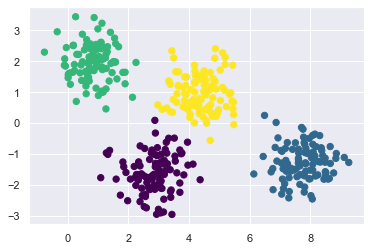

In [11]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Desde un punto de vista intuitivo, podríamos esperar que la asignación de agrupamiento para algunos puntos sea más segura que para otros: por ejemplo, parece haber una superposición muy leve entre los dos agrupamientos intermedios, por lo que es posible que no tengamos total confianza en la asignación del agrupamiento. de puntos entre ellos. Desafortunadamente, el modelo de k -medias no tiene una medida intrínseca de probabilidad o incertidumbre de las asignaciones de conglomerados (aunque puede ser posible utilizar un enfoque de arranque para estimar esta incertidumbre). Para ello, debemos pensar en generalizar el modelo.

Una forma de pensar en el modelo de k -medias es que coloca un círculo (o, en dimensiones más altas, una hiperesfera) en el centro de cada grupo, con un radio definido por el punto más distante del grupo. Este radio actúa como un límite estricto para la asignación de grupos dentro del conjunto de entrenamiento: cualquier punto fuera de este círculo no se considera miembro del grupo. Podemos visualizar este modelo de clúster con la siguiente función:

In [12]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

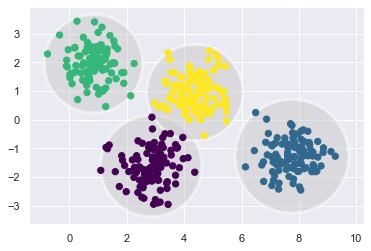

In [13]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Una observación importante para k -means es que estos modelos de conglomerados deben ser circulares : k -means no tiene una forma integrada de contabilizar conglomerados oblongos o elípticos. Entonces, por ejemplo, si tomamos los mismos datos y los transformamos, las asignaciones de clústeres terminan siendo confusas:

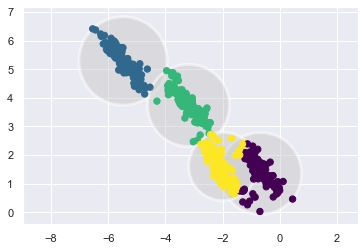

In [14]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

A simple vista, reconocemos que estos grupos transformados no son circulares y, por lo tanto, los grupos circulares no encajarían bien. Sin embargo, k-means no es lo suficientemente flexible para dar cuenta de esto y trata de forzar el ajuste de los datos en cuatro grupos circulares. Esto da como resultado una mezcla de asignaciones de conglomerados donde los círculos resultantes se superponen: vea especialmente la parte inferior derecha de esta gráfica. Uno podría imaginar abordar esta situación particular preprocesando los datos con PCA, pero en la práctica no hay garantía de que una operación global de este tipo circularice los datos individuales.

Estas dos desventajas de k-means (su falta de flexibilidad en la forma del grupo y la falta de asignación de grupo probabilística) significan que para muchos conjuntos de datos (especialmente conjuntos de datos de baja dimensión) es posible que no funcione tan bien como cabría esperar.

Podría imaginar abordar estas debilidades generalizando el modelo de k -medias: por ejemplo, podría medir la incertidumbre en la asignación de conglomerados comparando las distancias de cada punto con todos los centros de conglomerados, en lugar de centrarse solo en el más cercano. También puede imaginar permitir que los límites de los grupos sean elipses en lugar de círculos, para tener en cuenta los grupos no circulares. Resulta que estos son dos componentes esenciales de un tipo diferente de modelo de agrupamiento, los modelos de mezcla gaussiana.

## Generalizando E–M: Modelos Gaussianos de Mezcla 

Un modelo de mezcla gaussiana (GMM) intenta encontrar una mezcla de distribuciones de probabilidad gaussianas multidimensionales que modelen mejor cualquier conjunto de datos de entrada. En el caso más simple, los GMM se pueden usar para encontrar grupos de la misma manera que k -means:

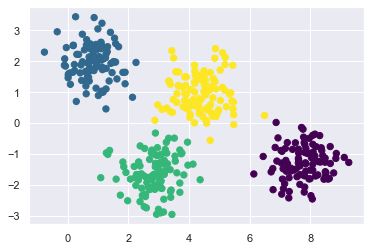

In [15]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Pero debido a que GMM contiene un modelo probabilístico bajo el capó, también es posible encontrar asignaciones de clústeres probabilísticos; en Scikit-Learn esto se hace usando del método predict_proba. Esto devuelve una matriz de tamaño [n_samples, n_clusters] que mide la probabilidad de que cualquier punto pertenezca al grupo dado:

In [16]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.    0.    0.537]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


Podemos visualizar esta incertidumbre, por ejemplo, haciendo que el tamaño de cada punto sea proporcional a la certeza de su predicción; Al observar la siguiente figura, podemos ver que son precisamente los puntos en los límites entre los grupos los que reflejan esta incertidumbre de asignación de grupos:

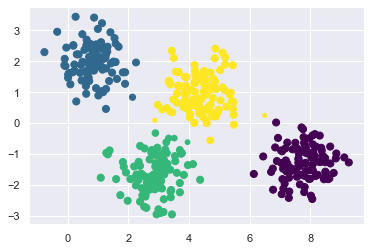

In [17]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Bajo el capó, un modelo de mezcla gaussiana es muy similar a k-means: utiliza un enfoque de maximización de expectativas que cualitativamente hace lo siguiente:

<ol>
    <li>Elija conjeturas iniciales para la ubicación y la forma</li>
    <li>Repita hasta que converja:
        <ul>
            <li>E-step : para cada punto, encuentre pesos que codifiquen la probabilidad de pertenencia en cada grupo</li>
            <li>M-step : para cada grupo, actualice su ubicación, normalización y forma en función de todos los puntos de datos, haciendo uso de los pesos</li>
        </ul>
    </li>
</ol>

El resultado de esto es que cada grupo no está asociado con una esfera de bordes duros, sino con un modelo gaussiano suave. Al igual que en el enfoque de maximización de la expectativa k -means, este algoritmo a veces puede perder la solución óptima global y, por lo tanto, en la práctica se utilizan múltiples inicializaciones aleatorias.

Vamos a crear una función que nos ayude a visualizar las ubicaciones y las formas de los grupos de GMM dibujando elipses según la salida de GMM:

In [18]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

Con esto en su lugar, podemos echar un vistazo a lo que nos da el GMM de cuatro componentes para nuestros datos iniciales:

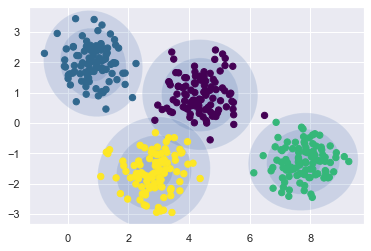

In [19]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

De manera similar, podemos usar el enfoque GMM para ajustar nuestro conjunto de datos ampliado; Permitiendo una covarianza completa, el modelo se ajustará incluso a clústeres muy oblongos y estirados:

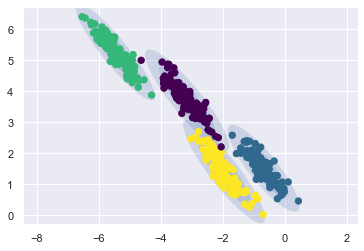

In [20]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Esto deja en claro que GMM aborda los dos problemas prácticos principales con k -means encontrados antes.

## GMM como Estimación de Densidad

Aunque GMM a menudo se clasifica como un algoritmo de agrupamiento, fundamentalmente es un algoritmo para la estimación de densidad . Es decir, el resultado de un ajuste de GMM a algunos datos técnicamente no es un modelo de agrupamiento, sino un modelo probabilístico generativo que describe la distribución de los datos.

Como ejemplo, considere algunos datos generados a partir de la función de Scikit-Learn **make_moons**, que vimos en In Depth: K-Means Clustering:

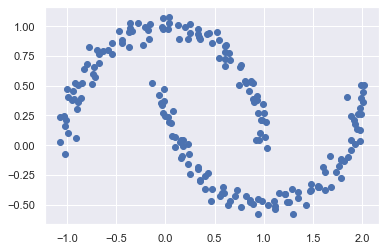

In [21]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Si tratamos de ajustar esto con un GMM de dos componentes visto como un modelo de agrupamiento, los resultados no son particularmente útiles:

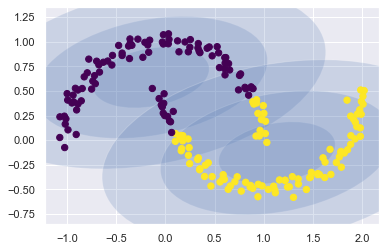

In [22]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Pero si, en cambio, usamos muchos más componentes e ignoramos las etiquetas de los grupos, encontramos un ajuste mucho más cercano a los datos de entrada:

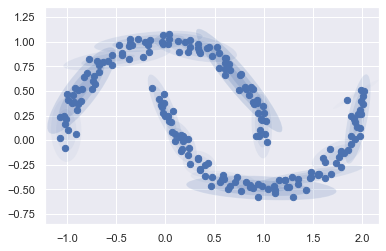

In [23]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Aquí, la combinación de 16 gaussianas no sirve para encontrar grupos de datos separados, sino para modelar la distribución general de los datos de entrada. Este es un modelo generativo de la distribución, lo que significa que el GMM nos da la receta para generar nuevos datos aleatorios distribuidos de manera similar a nuestra entrada. Por ejemplo, aquí hay 400 puntos nuevos extraídos de este GMM de 16 componentes que se ajusta a nuestros datos originales:

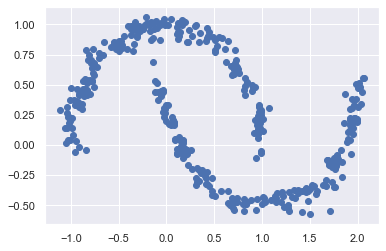

In [24]:
Xnew, Ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

GMM es conveniente como un medio flexible para modelar una distribución de datos multidimensional arbitraria.

### ¿Cuántos componentes?

El hecho de que GMM sea un modelo generativo nos brinda un medio natural para determinar la cantidad óptima de componentes para un conjunto de datos determinado. Un modelo generativo es inherentemente una distribución de probabilidad para el conjunto de datos, por lo que simplemente podemos evaluar la probabilidad de los datos bajo el modelo, utilizando la validación cruzada para evitar el ajuste excesivo. Otro medio de corregir el sobreajuste es ajustar las probabilidades del modelo utilizando algún criterio analítico, como el criterio de información de Akaike (AIC) o el criterio de información bayesiano (BIC) . El estimador de Scikit-Learn en realidad GMM incluye métodos integrados que calculan ambos, por lo que es muy fácil operar con este enfoque.

Veamos el AIC y el BIC como una función del número de componentes GMM para nuestro conjunto de datos lunares:

C:\Users\JuanMa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


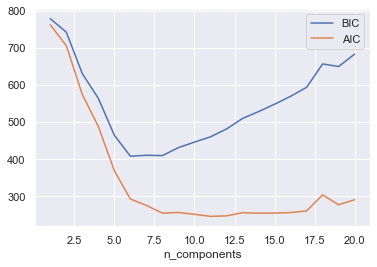

In [25]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

El número óptimo de clusters es el valor que minimiza el AIC o el BIC, según la aproximación que queramos utilizar. El AIC nos dice que nuestra elección de los 16 componentes anteriores probablemente fue demasiado: entre 8 y 12 componentes habría sido una mejor opción. Como es típico con este tipo de problema, el BIC recomienda un modelo más simple.

Observe el punto importante: esta elección de número de componentes mide qué tan bien funciona GMM como estimador de densidad , no qué tan bien funciona como algoritmo de agrupamiento . Lo animo a pensar en GMM principalmente como un estimador de densidad y usarlo para agrupar solo cuando se justifique dentro de conjuntos de datos simples.

## Ejemplo: GMM para generar nuevos datos

Acabamos de ver un ejemplo simple del uso de GMM como modelo generativo de datos para crear nuevas muestras a partir de la distribución definida por los datos de entrada. Aquí ejecutaremos esta idea y generaremos nuevos dígitos escritos a mano a partir del corpus de dígitos estándar que hemos usado antes.

Para empezar, carguemos los datos de los dígitos usando las herramientas de datos de Scikit-Learn:

In [26]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

A continuación, tracemos los primeros 100 de estos para recordar exactamente lo que estamos viendo:

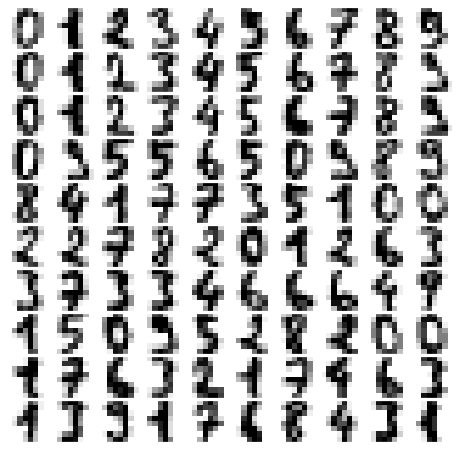

In [27]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Tenemos casi 1800 dígitos en 64 dimensiones, y podemos construir un GMM encima de estos para generar más. Los GMM pueden tener dificultades para converger en un espacio dimensional tan alto, por lo que comenzaremos con un algoritmo de reducción de dimensionalidad invertible en los datos. Aquí usaremos un PCA sencillo, pidiéndole que conserve el 99 % de la varianza en los datos proyectados:

In [28]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

El resultado son 41 dimensiones, una reducción de casi 1/3 casi sin pérdida de información. Dados estos datos proyectados, usemos el AIC para obtener un indicador de la cantidad de componentes GMM que debemos usar:

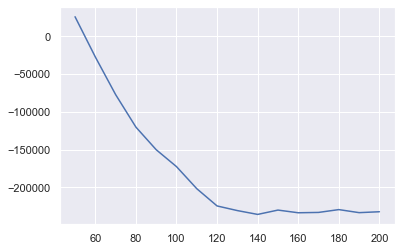

In [29]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

Parece que alrededor de 110 componentes minimiza el AIC; Usaremos este modelo. Ajustemos rápidamente esto a los datos y confirmemos que ha convergido:

In [30]:
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Ahora podemos dibujar muestras de 100 puntos nuevos dentro de este espacio proyectado de 41 dimensiones, usando el GMM como modelo generativo:

In [31]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

Finalmente, podemos usar la transformada inversa del objeto PCA para construir los nuevos dígitos:

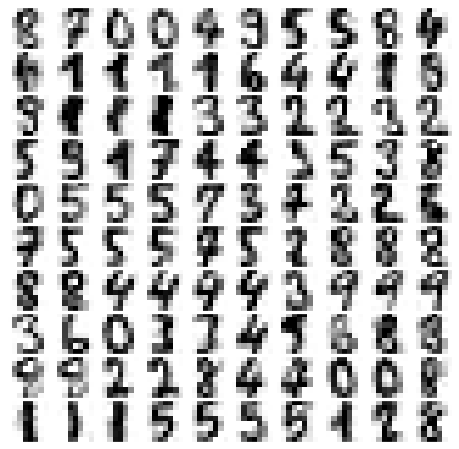

In [32]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)

**Conclusión del ejercicio:** Principalmente podemos decir que el GMM en este ejercicio es correcto, no falló, pues los dígitos generados a partir del dataset son prácticamente los mismos, son pocas las inperfecciones que se aprecian a simple vista, sin duda alguna esto demuestra el potencial que el algoritmo tiene para tareas de reconstruccion o recreación de de imagen.

## Conclusión General

En conclusión, el GMM es una de las mejores técnicas de clustering para obtener una estimación de la densidad de un conjunto de muestras utilizadas para el aprendizaje automático.

También cabe resaltar que son ampliamente utilizados, son robustos y cuando uno no dispone de mucha información sobre los datos, y no tiene manera de comprobar qué distribución de probabiliad siguen, la mejor opción es asumir que las muestras en un espacio n-dimensional se distribuyen de manera normal.

Por las carácteristicas mejoradas de GMM sobre k-means, GMM puede ser usado para hacer segmentación de imagenes, sonidos, documentos(contenido).